<a href="https://colab.research.google.com/github/e-cremente/physioex/blob/main/examples/freq_bands_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### colab setup

<a href="https://colab.research.google.com/github/e-cremente/physioex/blob/main/examples/freq_bands_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab setup
from google.colab import drive
drive.mount("/content/drive")

import os
working_dir = "/content/drive/MyDrive/Thesis"
os.chdir( working_dir )

!git clone https://github.com/e-cremente/physioex.git
%cd physioex

!git pull origin main
!pip install -e .

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from physioex.explain.freq_bands_explainer import FreqBandsExplainer
from loguru import logger

ckp_path = "models/cel/chambon2018/seqlen=3/dreem/dodh/"

expl = FreqBandsExplainer(
            model_name = "chambon2018",
            dataset_name  = "dreem",
            version = "dodh",
            use_cache = True,
            sequence_lenght  = 3,
            ckp_path = ckp_path,
            batch_size  = 32,
            #questo parametro da un errore. Non e' previsto dal costruttore della classe FreqBandsExplainer (e.c.)
            #n_jobs = 1
            )

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions 

2024-01-25 21:25:23.509 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:149 - JOB:0-Loading model <class 'physioex.train.networks.chambon2018.Chambon2018Net'> from checkpoint models/cel/chambon2018/seqlen=3/dreem/dodh/fold=0-epoch=8-step=5030-val_acc=0.87.ckpt
2024-01-25 21:25:24.692 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:154 - JOB:0-Splitting dataset into train, validation and test sets
2024-01-25 21:25:24.955 | INFO     | physioex.data.dreem:split:198 - Train shape X (19019, 1, 3000), y (19019,)
2024-01-25 21:25:24.956 | INFO     | physioex.data.dreem:split:199 - Valid shape X (3714, 1, 3000), y (3714,)
2024-01-25 21:25:24.959 | INFO     | physioex.data.dreem:split:200 - Test shape X (1929, 1, 3000), y (1929,)
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_pro

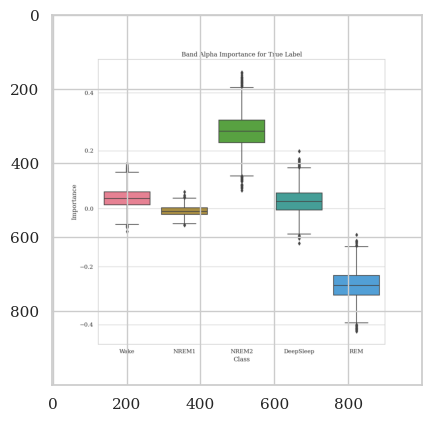

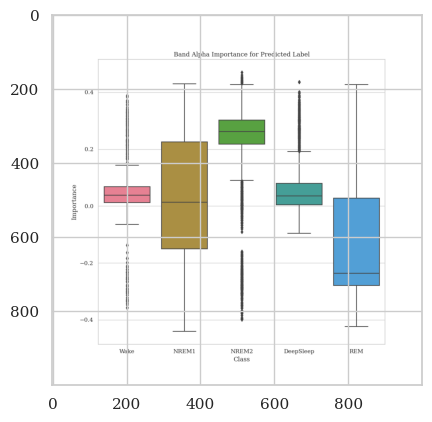

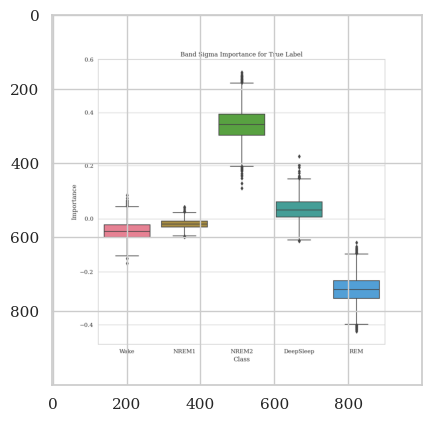

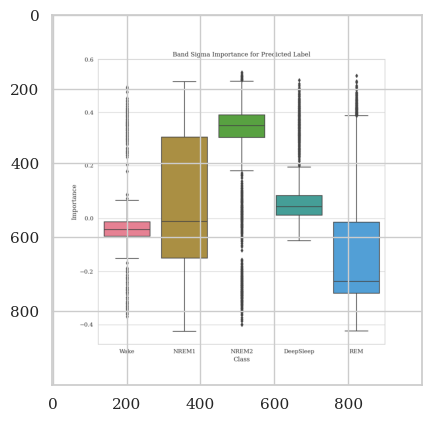

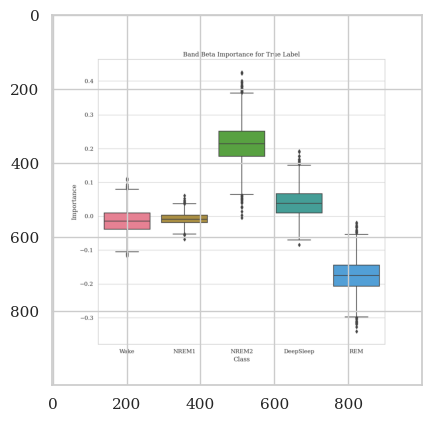

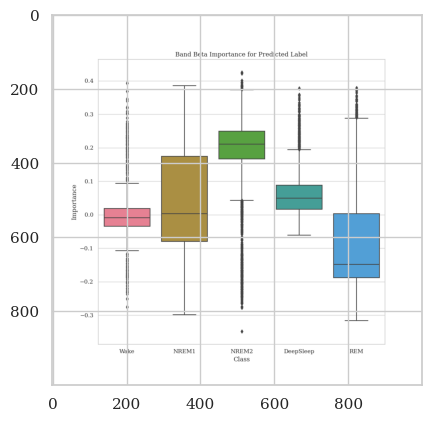

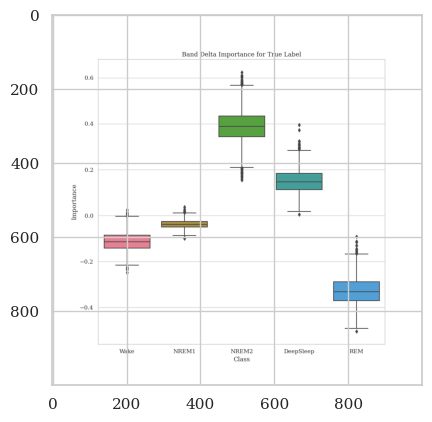

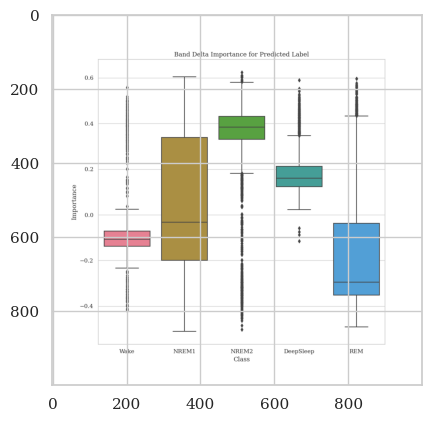

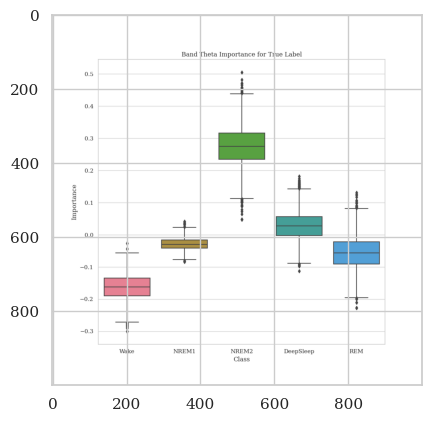

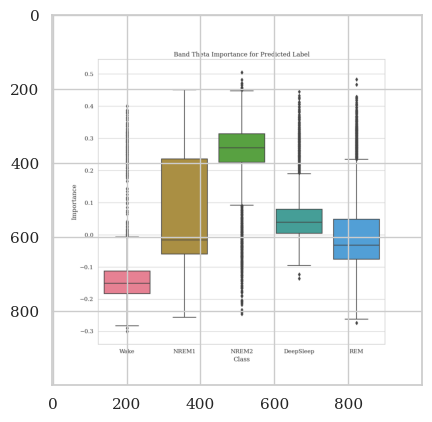

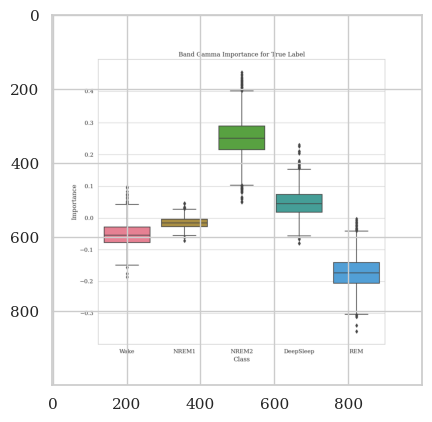

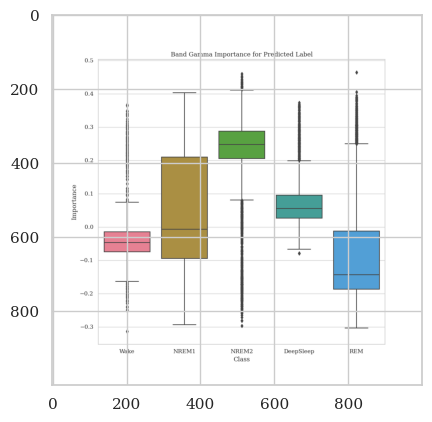

In [3]:
#cambiato Gamma da [30, 50] a [30, 49.5] perche' con un sampling rate di 100hz, il filtro che tagliasse fuori frequenze di 50hz non era applicabile (e.c.)
sleep_bands = [[8, 11.5], [11.5, 15.5], [15.5, 30], [0.5, 4], [4, 8], [30, 49.5]]
sleep_bands_names = ['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']

expl.explain(sleep_bands, sleep_bands_names, save_csv= True,  plot_pred = True, plot_true = True, n_jobs = 1)

for i in range(len(sleep_bands)):
    # plot the results of the 0 fold simple importance
    img = mpimg.imread( ckp_path + 'fold=0_true_band=' + sleep_bands_names[i] + '_simple_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    img = mpimg.imread( ckp_path + 'fold=0_pred_band=' + sleep_bands_names[i] + '_simple_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    # plot the results of the 0 fold weighted importance
    img = mpimg.imread( ckp_path + 'fold=0_true_band=' + sleep_bands_names[i] + '_weighted_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    img = mpimg.imread( ckp_path + 'fold=0_pred_band=' + sleep_bands_names[i] + '_weighted_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    # plot the results of the 0 fold normalized importance
    img = mpimg.imread( ckp_path + 'fold=0_true_band=' + sleep_bands_names[i] + '_normalized_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    img = mpimg.imread( ckp_path + 'fold=0_pred_band=' + sleep_bands_names[i] + '_normalized_importance.png')
    imgplot = plt.imshow(img)
    plt.show()
